In [13]:
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from funcs.logic import process_pdfs_to_faiss_with_positions
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import TypedDict, List, Optional
from langgraph.graph import StateGraph
from funcs.logic import get_qa_score

source_dir = "data/source/pdf"
output_dir = "data/vectordb/pdf_fitz"
embedding_model = "intfloat/multilingual-e5-small"
# embedding_model = "intfloat/multilingual-e5-large-instruct"


In [14]:
# 벡터 데이터 베이스에 임베딩
process_pdfs_to_faiss_with_positions(
    pdf_dir= source_dir,
    output_dir=output_dir,
    embedding_model_name=embedding_model,
    chunk_size=500,
    chunk_overlap=50
)

PDF 추출 중: 100%|██████████| 3/3 [00:00<00:00, 15.51it/s]


[Document(metadata={'source': 'data/source/pdf/카카오계정약관20240416.pdf', 'page': 0, 'bbox': (166.309814453125, 171.3964385986328, 432.3580627441406, 217.9996337890625), 'offset': 0, 'length': 10}, page_content='카카오계정 약관  '), Document(metadata={'source': 'data/source/pdf/카카오계정약관20240416.pdf', 'page': 0, 'bbox': (227.559814453125, 653.79638671875, 371.10791015625, 700.3995971679688), 'offset': 0, 'length': 6}, page_content='㈜카카오  '), Document(metadata={'source': 'data/source/pdf/카카오계정약관20240416.pdf', 'page': 1, 'bbox': (84.95994567871094, 198.2150115966797, 220.14776611328125, 216.72860717773438), 'offset': 0, 'length': 14}, page_content='제 1 장 환영합니다!  '), Document(metadata={'source': 'data/source/pdf/카카오계정약관20240416.pdf', 'page': 1, 'bbox': (84.95994567871094, 285.0239562988281, 170.0530242919922, 300.98394775390625), 'offset': 0, 'length': 12}, page_content='제 1 조 (목적)  '), Document(metadata={'source': 'data/source/pdf/카카오계정약관20240416.pdf',

In [15]:
# 1️⃣ FAISS 벡터 DB 로드
qa_tokenizer = AutoTokenizer.from_pretrained("Dongjin-kr/ko-reranker")
qa_model = AutoModelForSequenceClassification.from_pretrained("Dongjin-kr/ko-reranker")

vector_db = FAISS.load_local(
    output_dir,
    HuggingFaceEmbeddings(model_name=embedding_model),
    allow_dangerous_deserialization=True  # 보안 옵션 추가
)

In [16]:
# LangGraph pipeline 실행
class QAState(TypedDict):
    question: str
    retrieved_docs: Optional[List]
    reranked_docs: Optional[List]
    top_docs: Optional[List]
    answer: Optional[str]


def retrieve_documents(state: QAState):
    question = state["question"]
    retrieved_docs = vector_db.similarity_search_with_score(question, k=30)
    return {"retrieved_docs": retrieved_docs}


def rerank_documents(state: QAState):
    question = state["question"]
    retrieved_docs = state["retrieved_docs"]

    scored_docs = []
    _score = []
    for doc, _ in retrieved_docs:
        score = get_qa_score(question, doc.page_content, qa_tokenizer, qa_model)
        scored_docs.append((doc, score))
        _score.append(score)

    _average = sum(_score) / len(_score)

    reranked_docs = sorted(scored_docs, key=lambda x: x[1], reverse=True)
    # top_docs = [doc for doc, _ in reranked_docs[:10]]
    top_docs = []
    for doc, score in reranked_docs[:10]:
        doc.metadata["score"] = score
        if score > _average:
            top_docs.append(doc)

    return {
        "reranked_docs": reranked_docs,
        "top_docs": top_docs,
    }





In [17]:
graph = StateGraph(QAState)

graph.add_node("retrieve_documents", retrieve_documents)
graph.add_node("rerank_documents", rerank_documents)

graph.set_entry_point("retrieve_documents")
graph.add_edge("retrieve_documents", "rerank_documents")


graph.set_finish_point("retrieve_documents")

qa_graph = graph.compile()


In [18]:
import csv

# CSV 파일을 읽어 딕셔너리 리스트로 저장
data_list = []
with open("data/checklist.csv", newline='', encoding="utf-8-sig") as csvfile:
    reader = csv.DictReader(csvfile)  # 각 행을 딕셔너리로 변환
    for row in reader:
        op = {
            'code':row['code'],
            'item':row['item'],
            'exp' : row['exp'],
              }
        result = qa_graph.invoke({"question": f"{row['item']}"})

        op['result'] = result
        data_list.append(op)

/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/peter/Documents/.virtual/RAG_experiments/lib/python3.11/site-packages/IPy

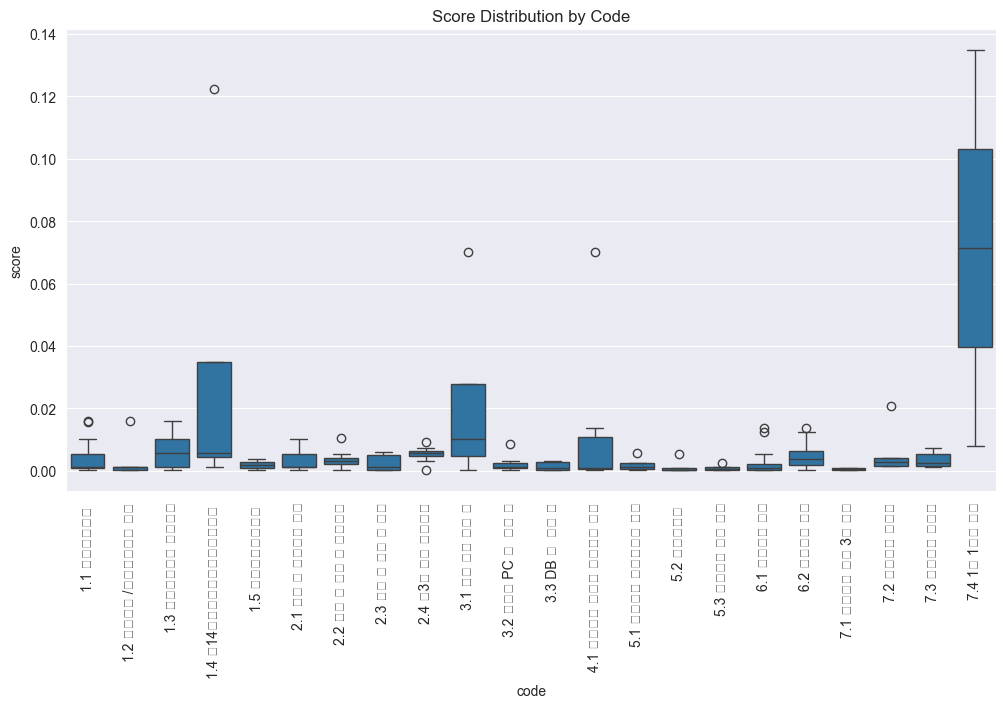

In [19]:
import pandas as pd


result_list = []
for _documents in data_list:
    for _docs in _documents['result']['top_docs']:
        _dummy = {
            "code":_documents['code'],
            "item":_documents['item'],
            "page_content": _docs.page_content,
            "score": _docs.metadata['score'],
        }
        result_list.append(_dummy)


df = pd.DataFrame(result_list)



mean_scores = df.groupby('code')['score'].mean().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt




# 박스 플롯 그리기
plt.figure(figsize=(12, 6))
sns.boxplot(x='code', y='score', data=df)
plt.xticks(rotation=90)
plt.title('Score Distribution by Code')
plt.show()

In [21]:
result = qa_graph.invoke({"question": f"이용제한과 관련하여 조치 결과가 불만족스러울 경우 고객센터를 통해 이의를 제기할 수 있습니까?"})

In [23]:
result['top_docs']

[Document(id='7fe52b61-07da-45eb-af23-8b1b5b6d58d5', metadata={'source': 'data/source/pdf/카카오 서비스 약관20230109.pdf', 'page': 4, 'bbox': (85.08000183105469, 685.85400390625, 512.2584228515625, 697.2084350585938), 'offset': 0, 'length': 63, 'score': 0.99994957447052}, page_content='여러분은# 이용제한과# 관련하여# 조치# 결과가# 불만족스러울# 경우# 고객센터를# 통해# 이의를# 제기할# 수#'),
 Document(id='21a7d8a1-8527-4fbb-867d-d07a14a1d4bd', metadata={'source': 'data/source/pdf/카카오계정약관20240416.pdf', 'page': 13, 'bbox': (98.85986328125, 197.35292053222656, 434.5955810546875, 210.7593231201172), 'offset': 0, 'length': 39, 'score': 0.9999492168426514}, page_content='결과가 불만족스러울 경우 고객센터를 통해 이의를 제기할 수 있습니다. ')]